In [1]:
from utils import *
from sklearn import metrics
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
import pandas as pd
plt.style.use('default')
plt.rc('font', size=16, family='serif')
plt.rc('mathtext', default='it', fontset='cm')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
datasets = []
datasets_std = []

In [133]:
name = 'Friedman 1'
noise = 1.5

X_train, y_train = make_friedman1(noise=0.0, random_state=18397425)
_, y_train_noisy = make_friedman1(noise=noise, random_state=18397425)
X_norm_train= normalize(X_train, axis=1)

X_test, y_test = make_friedman1(noise=0.0, random_state=30189745)
_, y_test_noisy = make_friedman1(noise=noise, random_state=30189745)
X_norm_test= normalize(X_test, axis=1)

# [X_train, y_train, X_test, y_test, X_draw, norm, noise, name]
datasets.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name])
datasets.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name])
datasets.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name])
datasets.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name])

print(X_test[0])

for i in range(0, X_train.shape[1]):
    X_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])
    X_test[:,i] = (X_test[:,i] - np.mean(X_test[:,i])) / np.std(X_test[:,i])

print(X_test[0])

X_norm_train = normalize(X_train, axis=1)
X_norm_test = normalize(X_test, axis=1)

datasets_std.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name + ' Std'])
datasets_std.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name + ' Std'])
datasets_std.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name + ' Std'])
datasets_std.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name + ' Std'])

[0.14734293 0.96969391 0.7031536  0.59113441 0.28890767 0.99933427
 0.34536703 0.6296617  0.23879122 0.346948  ]
[-1.36630824  1.64229288  0.74995799  0.40723948 -0.83883613  1.78141897
 -0.69289087  0.49638197 -1.00721333 -0.64278257]


In [6]:
name = 'Friedman 2'
noise = 5

X_train, y_train = make_friedman2(noise=0.0, random_state=18397425)
_, y_train_noisy = make_friedman2(noise=noise, random_state=18397425)
X_norm_train= normalize(X_train, axis=1)

X_test, y_test = make_friedman2(noise=0.0, random_state=30189745)
_, y_test_noisy = make_friedman2(noise=noise, random_state=30189745)
X_norm_test= normalize(X_test, axis=1)

# [X_train, y_train, X_test, y_test, X_draw, norm, noise, name]
datasets.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name])
datasets.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name])
datasets.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name])
datasets.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name])

for i in range(0, X_train.shape[1]):
    X_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])
    X_test[:,i] = (X_test[:,i] - np.mean(X_test[:,i])) / np.std(X_test[:,i])

X_norm_train = normalize(X_train, axis=1)
X_norm_test = normalize(X_test, axis=1)

datasets_std.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name + ' Std'])
datasets_std.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name + ' Std'])
datasets_std.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name + ' Std'])
datasets_std.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name + ' Std'])

In [7]:
name = 'Friedman 3'
noise = 0.15

X_train, y_train = make_friedman3(noise=0.0, random_state=18397425)
_, y_train_noisy = make_friedman3(noise=noise, random_state=18397425)
X_norm_train= normalize(X_train, axis=1)

X_test, y_test = make_friedman3(noise=0.0, random_state=30189745)
_, y_test_noisy = make_friedman3(noise=noise, random_state=30189745)
X_norm_test= normalize(X_test, axis=1)

# [X_train, y_train, X_test, y_test, X_draw, norm, noise, name]
datasets.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name])
datasets.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name])
datasets.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name])
datasets.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name])

for i in range(0, X_train.shape[1]):
    X_train[:,i] = (X_train[:,i] - np.mean(X_train[:,i])) / np.std(X_train[:,i])
    X_test[:,i] = (X_test[:,i] - np.mean(X_test[:,i])) / np.std(X_test[:,i])

X_norm_train = normalize(X_train, axis=1)
X_norm_test = normalize(X_test, axis=1)

datasets_std.append([X_train, y_train, X_test, y_test, X_test, False, 0.0, name + ' Std'])
datasets_std.append([X_train, y_train_noisy, X_test, y_test_noisy, X_test, False, noise, name + ' Std'])
datasets_std.append([X_norm_train, y_train, X_norm_test, y_test, X_test, True, 0.0, name + ' Std'])
datasets_std.append([X_norm_train, y_train_noisy, X_norm_test, y_test_noisy, X_test, True, noise, name + ' Std'])

In [6]:
%%capture
depths = (2, 3, 10)
experiment_output = []
for dataset in datasets:
    for depth in depths:
        experiment_output.append(experiment(dataset, depth=depth, log=True))

In [7]:
%%capture
depths = (2, 3, 10)
experiment_output_std = []
for dataset in datasets_std:
    for depth in depths:
        experiment_output_std.append(experiment(dataset, depth=depth, log=True))

In [8]:
all_outputs = {}
all_outputs['norm_y'] = experiment_output
all_outputs['norm_y_rescale'] = experiment_output_std

In [9]:
%%capture
depths = (2, 3, 10)
experiment_output = []
for dataset in datasets:
    for depth in depths:
        experiment_output.append(experiment(dataset, depth=depth, log=True, norm_y=False))

In [10]:
%%capture
depths = (2, 3, 10)
experiment_output_std = []
for dataset in datasets_std:
    for depth in depths:
        experiment_output_std.append(experiment(dataset, depth=depth, log=True, norm_y=False))

In [11]:
all_outputs['none'] = experiment_output
all_outputs['rescale'] = experiment_output_std

In [10]:
print(all_outputs.keys())

dict_keys(['norm_y', 'norm_y_rescale', 'none', 'rescale'])


In [13]:
# save_data(all_outputs, 'exp_norm_test')

In [9]:
all_outputs = load_data('./exp_norm_test')

In [131]:
all_outputs['none'][0]['dataset']['test'][0][0], all_outputs['rescale'][0]['dataset']['test'][0][0]

(array([0.14734293, 0.96969391, 0.7031536 , 0.59113441, 0.28890767,
        0.99933427, 0.34536703, 0.6296617 , 0.23879122, 0.346948  ]),
 array([0.14734293, 0.96969391, 0.7031536 , 0.59113441, 0.28890767,
        0.99933427, 0.34536703, 0.6296617 , 0.23879122, 0.346948  ]))

In [125]:
np.sqrt(np.mean((all_outputs['norm_y'][0]['dataset']['test'][1] - all_outputs['norm_y'][0]['means'][1])**2))

5.921510521854781

In [126]:
np.sqrt(np.mean((all_outputs['norm_y_rescale'][0]['dataset']['test'][1] - all_outputs['norm_y_rescale'][0]['means'][1])**2))

5.921510521854781

In [69]:
depths=(2,3,10)
arrays = [
    ['Friedman 1', 'Friedman 1 Std', 'Friedman 2', 'Friedman 2 Std', 'Friedman 3', 'Friedman 3 Std'],
    [False, True],  # Noise
]

index = pd.MultiIndex.from_product(
    arrays, names=["Dataset", "Noise"])


df_gaus_sd = pd.DataFrame(
    index=index,
    columns=['D2rmse', 'D3rmse',  'D10rmse', 'D2r', 'D3r',  'D10r', 'D2corr', 'D3corr', 'D10corr'])

# df_lap_sd = pd.DataFrame(
#     index=index,
#     columns=['D2rmse', 'D3rmse',  'D10rmse', 'D2r', 'D3r',  'D10r', 'D2corr', 'D3corr', 'D10corr'])

df_lap_sd = df_gaus_sd.copy(deep=True)

df_gaus_sd_norm_y = df_gaus_sd.copy(deep=True)
df_lap_sd_norm_y = df_gaus_sd.copy(deep=True)

df_gaus_rd = df_gaus_sd.copy(deep=True)
df_lap_rd = df_gaus_sd.copy(deep=True)

df_gaus_rd_norm_y = df_gaus_sd.copy(deep=True)
df_lap_rd_norm_y = df_gaus_sd.copy(deep=True)

df_ntk_sd = df_gaus_sd.copy(deep=True)
df_ntk_sd_norm_y = df_gaus_sd.copy(deep=True)

df_ntk_rd = df_gaus_sd.copy(deep=True)
df_ntk_rd_norm_y = df_gaus_sd.copy(deep=True)

In [70]:
experiment_output = all_outputs['none']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

experiment_output = all_outputs['rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

In [71]:
experiment_output = all_outputs['norm_y']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

experiment_output = all_outputs['norm_y_rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_ntk_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_sd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']
    else:
        df_ntk_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['ntk']['data_rmse']
        df_ntk_rd_norm_y[f'D{depth}r'][name, noisy] = exp['ntk']['r2']
        df_ntk_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['ntk']['data_corr']

In [72]:
experiment_output = all_outputs['none']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

experiment_output = all_outputs['rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

In [73]:
experiment_output = all_outputs['norm_y']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

experiment_output = all_outputs['norm_y_rescale']

for exp in experiment_output:
    depth = exp['kernel']['depth']
    name = exp['dataset']['name']
    noise = exp['dataset']['noise']

    if noise==0.0: 
        noisy = False 
    else: 
        noisy = True

    if exp['dataset']['norm']:
        df_lap_sd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_sd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_sd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_sd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_sd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_sd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']
    else:
        df_lap_rd_norm_y[f'D{depth}rmse'][name, noisy]  = exp['lap']['pred_rmse']
        df_lap_rd_norm_y[f'D{depth}r'][name, noisy] = exp['lap']['r2']
        df_lap_rd_norm_y[f'D{depth}corr'][name, noisy]  = exp['lap']['pred_corr']
        df_gaus_rd_norm_y[f'D{depth}rmse'][name, noisy] = exp['gaus']['pred_rmse']
        df_gaus_rd_norm_y[f'D{depth}r'][name, noisy] = exp['gaus']['r2']
        df_gaus_rd_norm_y[f'D{depth}corr'][name, noisy] = exp['gaus']['pred_corr']

In [254]:
print(df_ntk_sd.style.to_latex())

\begin{tabular}{lllllllllll}
 &  & D2rmse & D3rmse & D10rmse & D2r & D3r & D10r & D2corr & D3corr & D10corr \\
Dataset & Noise &  &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{Friedman 1} & 0 & 3.053503 & 3.083053 & 3.305223 & 0.654859 & 0.648147 & 0.595609 & 0.809457 & 0.805592 & 0.782017 \\
 & 1 & 3.515408 & 3.513361 & 3.676093 & 0.591945 & 0.592420 & 0.553789 & 0.771826 & 0.771411 & 0.751887 \\
\multirow[c]{2}{*}{Friedman 1 Std} & 0 & 8.323547 & 7.829316 & 5.939072 & -1.564581 & -1.269066 & -0.305680 & 0.726612 & 0.716501 & 0.676303 \\
 & 1 & 8.004236 & 7.600599 & 6.030748 & -1.115471 & -0.907493 & -0.200908 & 0.744744 & 0.738704 & 0.704765 \\
\multirow[c]{2}{*}{Friedman 2} & 0 & 426.421523 & 426.612048 & 427.118452 & -0.068800 & -0.069755 & -0.072296 & 0.234370 & 0.233479 & 0.231218 \\
 & 1 & 384.117369 & 383.964326 & 385.869937 & 0.136250 & 0.136938 & 0.128350 & 0.429753 & 0.423029 & 0.393539 \\
\multirow[c]{2}{*}{Friedman 2 Std} & 0 & 487.375364 & 483.959521 & 457.523539 & -0.396

In [255]:
print(df_ntk_sd_norm_y.style.to_latex())

\begin{tabular}{lllllllllll}
 &  & D2rmse & D3rmse & D10rmse & D2r & D3r & D10r & D2corr & D3corr & D10corr \\
Dataset & Noise &  &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{Friedman 1} & 0 & 3.098101 & 3.138870 & 3.374442 & 0.644704 & 0.635291 & 0.578494 & 0.803434 & 0.798136 & 0.772320 \\
 & 1 & 3.548121 & 3.557875 & 3.730027 & 0.584315 & 0.582027 & 0.540600 & 0.766492 & 0.764490 & 0.743339 \\
\multirow[c]{2}{*}{Friedman 1 Std} & 0 & 8.641746 & 8.165398 & 6.194285 & -1.764410 & -1.468052 & -0.420306 & 0.703818 & 0.706537 & 0.678755 \\
 & 1 & 8.078471 & 7.743910 & 6.223272 & -1.154892 & -0.980103 & -0.278807 & 0.741171 & 0.741643 & 0.710646 \\
\multirow[c]{2}{*}{Friedman 2} & 0 & 426.830806 & 426.878934 & 427.179795 & -0.070853 & -0.071094 & -0.072604 & 0.232490 & 0.232273 & 0.230944 \\
 & 1 & 386.368478 & 386.208014 & 385.814425 & 0.126096 & 0.126822 & 0.128601 & 0.437207 & 0.436010 & 0.430951 \\
\multirow[c]{2}{*}{Friedman 2 Std} & 0 & 489.780179 & 486.838718 & 461.446850 & -0.410

In [76]:
df_ntk_rd

D2rmse         D3rmse        D10rmse            D2r  \
Dataset        Noise                                                            
Friedman 1     False    6.245068       6.361248        5.19497       -0.44369   
               True     6.046664       6.078972       5.135057      -0.207255   
Friedman 1 Std False    6.245068       6.361248        5.19497       -0.44369   
               True     6.046664       6.078972       5.135057      -0.207255   
Friedman 2     False   492.04035  236801.542625     455.977685      -0.423048   
               True    493.35638  239225.125166  196782.200209      -0.424891   
Friedman 2 Std False   492.04035  236801.542625     455.977685      -0.423048   
               True    493.35638  239225.125166  196782.200209      -0.424891   
Friedman 3     False   26.793687      23.618989        2.75366   -14798.44832   
               True   111.465501      93.109976      56.694613 -177375.158712   
Friedman 3 Std False   26.793687      23.618989        2.75366   -14798.44832   
               True   111.465501      93.109976      56.694613 -177375.158712   

                                D3r           D10r    D2corr    D3corr  \
Dataset        Noise                                                     
Friedman 1     False      -0.497905          0.001  0.825023   0.80093   
               True        -0.22019       0.129322  0.820967  0.809961   
Friedman 1 Std False      -0.497905          0.001  0.825023   0.80093   
               True        -0.22019       0.129322  0.820967  0.809961   
Friedman 2     False -329599.041879      -0.222096  0.402773  0.639759   
               True  -335021.278478 -226688.670452  0.402478  0.640253   
Friedman 2 Std False -329599.041879      -0.222096  0.402773  0.639759   
               True  -335021.278478 -226688.670452  0.402478  0.640253   
Friedman 3     False  -11499.141507    -155.315218  0.499361  0.489061   
               True  -123766.533623  -45886.869069  0.503159  0.502316   
Friedman 3 Std False  -11499.141507    -155.315218  0.499361  0.489061   
               True  -123766.533623  -45886.869069  0.503159  0.502316   

                       D10corr  
Dataset        Noise            
Friedman 1     False  0.768435  
               True   0.794734  
Friedman 1 Std False  0.768435  
               True   0.794734  
Friedman 2     False  0.068488  
               True   0.640288  
Friedman 2 Std False  0.068488  
               True   0.640288  
Friedman 3     False -0.466009  
               True   0.489899  
Friedman 3 Std False -0.466009  
               True   0.489899

In [77]:
df_ntk_rd_norm_y

D2rmse         D3rmse        D10rmse  \
Dataset        Noise                                                
Friedman 1     False       5.910543       5.727827       5.076565   
               True        5.777626       5.677645       5.269707   
Friedman 1 Std False       5.910543       5.727827       5.076565   
               True        5.777626       5.677645       5.269707   
Friedman 2     False  237150.464367  231366.083818  182554.924244   
               True   241022.938571  234226.489201   183527.88648   
Friedman 2 Std False  237150.464367  231366.083818  182554.924244   
               True   241022.938571  234226.489201   183527.88648   
Friedman 3     False       8.763549      22.923852      19.326551   
               True       54.699511      53.773852      31.837821   
Friedman 3 Std False       8.763549      22.923852      19.326551   
               True       54.699511      53.773852      31.837821   

                                D2r            D3r           D10r    D2corr  \
Dataset        Noise                                                          
Friedman 1     False      -0.293166      -0.214449        0.04602  0.832482   
               True       -0.102214      -0.064397       0.083062  0.817855   
Friedman 1 Std False      -0.293166      -0.214449        0.04602  0.832482   
               True       -0.102214      -0.064397       0.083062  0.817855   
Friedman 2     False -330571.073969 -314641.652773 -195885.861478  0.639822   
               True  -340075.687036 -321166.894556 -197179.622569  0.640316   
Friedman 2 Std False -330571.073969 -314641.652773 -195885.861478  0.639822   
               True  -340075.687036 -321166.894556 -197179.622569  0.640316   
Friedman 3     False   -1582.217431  -10832.175242    -7698.97458 -0.345043   
               True   -42714.076804   -41280.60788  -14470.081354  0.509007   
Friedman 3 Std False   -1582.217431  -10832.175242    -7698.97458 -0.345043   
               True   -42714.076804   -41280.60788  -14470.081354  0.509007   

                        D3corr   D10corr  
Dataset        Noise                      
Friedman 1     False  0.833024  0.822231  
               True   0.819116  0.807047  
Friedman 1 Std False  0.833024  0.822231  
               True   0.819116  0.807047  
Friedman 2     False  0.639873  0.640188  
               True   0.640365  0.640671  
Friedman 2 Std False  0.639873  0.640188  
               True   0.640365  0.640671  
Friedman 3     False  -0.44647  -0.47124  
               True   0.508122   0.51303  
Friedman 3 Std False  -0.44647  -0.47124  
               True   0.508122   0.51303

In [259]:
df_lap_sd

D2rmse    D3rmse   D10rmse       D2r       D3r  \
Dataset        Noise                                                     
Friedman 1     False  0.369145  0.288527  0.354485  0.639155  0.637018   
               True   0.352764  0.319358  0.369319  0.572927   0.57831   
Friedman 1 Std False  0.027102  0.024974  0.218672 -1.565682 -1.265459   
               True   0.128483  0.072482  0.210674 -1.122017 -0.908318   
Friedman 2     False  1.912787  0.846103  0.037873 -0.070587 -0.070594   
               True   1.742755  1.062736  0.531244  0.134191  0.135752   
Friedman 2 Std False  0.769557  0.646578  0.821099 -0.394722 -0.375412   
               True    0.28918  0.470784  0.791099 -0.408611 -0.382177   
Friedman 3     False  0.000009  0.000036  0.000379 -0.198036 -0.200114   
               True    0.00042  0.000536  0.000332  0.062216  0.063351   
Friedman 3 Std False  0.000692  0.000141  0.001685 -0.259021 -0.225822   
               True   0.000191  0.001094  0.000327 -0.127168 -0.100345   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.622037  0.997359  0.998318  0.998521  
               True   0.573489  0.998484  0.998818  0.998443  
Friedman 1 Std False -0.271805  0.999864  0.999899  0.996286  
               True  -0.167456  0.996732  0.998768  0.996685  
Friedman 2     False -0.072268  0.999966  0.999993       1.0  
               True    0.12877  0.999923  0.999973  0.999995  
Friedman 2 Std False  -0.23213  0.999343  0.999341  0.797503  
               True   -0.23023  0.999869  0.999826  0.772855  
Friedman 3     False  -0.21095       1.0       1.0  0.999999  
               True    0.02495  0.999998  0.999997  0.999999  
Friedman 3 Std False -0.114681  0.997137  0.999804  0.999013  
               True   0.003625   0.99993  0.999285  0.998697

In [258]:
print(df_lap_sd_norm_y.round(4).style.to_latex())

\begin{tabular}{lllllllllll}
 &  & D2rmse & D3rmse & D10rmse & D2r & D3r & D10r & D2corr & D3corr & D10corr \\
Dataset & Noise &  &  &  &  &  &  &  &  &  \\
\multirow[c]{2}{*}{Friedman 1} & 0 & 0.287552 & 0.192716 & 0.149625 & 0.638026 & 0.633121 & 0.574724 & 0.998107 & 0.999072 & 0.999192 \\
 & 1 & 0.204771 & 0.232242 & 0.153441 & 0.573340 & 0.573300 & 0.536773 & 0.999493 & 0.999231 & 0.999260 \\
\multirow[c]{2}{*}{Friedman 1 Std} & 0 & 0.334710 & 0.178345 & 0.023995 & -1.727920 & -1.461315 & -0.419638 & 0.979201 & 0.993115 & 0.999781 \\
 & 1 & 0.300469 & 0.160416 & 0.023810 & -1.169370 & -0.989119 & -0.276821 & 0.983033 & 0.994387 & 0.999794 \\
\multirow[c]{2}{*}{Friedman 2} & 0 & 0.005028 & 0.017825 & 0.187499 & -0.070847 & -0.071085 & -0.072530 & 1.000000 & 1.000000 & 1.000000 \\
 & 1 & 2.544898 & 1.659793 & 1.133928 & 0.123886 & 0.125374 & 0.129723 & 0.999781 & 0.999911 & 0.999967 \\
\multirow[c]{2}{*}{Friedman 2 Std} & 0 & 0.670750 & 0.584711 & 0.234844 & -0.408773 & -0.391997 & 

In [81]:
df_lap_rd

D2rmse         D3rmse        D10rmse       D2r  \
Dataset        Noise                                                       
Friedman 1     False    0.310843       0.429618       1.867202 -0.457136   
               True     0.323977       0.408051       1.922903 -0.240275   
Friedman 1 Std False    0.310843       0.429618       1.867202 -0.457136   
               True     0.323977       0.408051       1.922903 -0.240275   
Friedman 2     False   98.433619  236432.202013     120.027831 -0.866949   
               True   196.693918  238859.751705  196409.288647 -0.202381   
Friedman 2 Std False   98.433619  236432.202013     120.027831 -0.866949   
               True   196.693918  238859.751705  196409.288647 -0.202381   
Friedman 3     False    26.81511      23.635746       1.546771  0.088713   
               True   111.587977      93.275739      56.755206  -0.09274   
Friedman 3 Std False    26.81511      23.635746       1.546771  0.088713   
               True   111.587977      93.275739      56.755206  -0.09274   

                           D3r       D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                                     
Friedman 1     False -0.457805  -0.555661  0.980144  0.957862  0.010327  
               True  -0.240242  -0.365736  0.980824  0.969279 -0.129406  
Friedman 1 Std False -0.457805  -0.555661  0.980144  0.957862  0.010327  
               True  -0.240242  -0.365736  0.980824  0.969279 -0.129406  
Friedman 2     False  -1.59783  -0.742277 -0.611762 -0.863939  0.192174  
               True  -1.567442  -1.613125 -0.612735 -0.841933 -0.837213  
Friedman 2 Std False  -1.59783  -0.742277 -0.611762 -0.863939  0.192174  
               True  -1.567442  -1.613125 -0.612735 -0.841933 -0.837213  
Friedman 3     False  0.082927 -36.680311  0.506122  0.483154  0.757965  
               True  -0.215014   0.019209 -0.861792 -0.971362  -0.31547  
Friedman 3 Std False  0.082927 -36.680311  0.506122  0.483154  0.757965  
               True  -0.215014   0.019209 -0.861792 -0.971362  -0.31547

In [82]:
df_lap_rd_norm_y

D2rmse         D3rmse        D10rmse       D2r  \
Dataset        Noise                                                          
Friedman 1     False       0.331602       0.296992       0.354676  -0.29797   
               True        0.347588       0.283673       0.171291 -0.127093   
Friedman 1 Std False       0.331602       0.296992       0.354676  -0.29797   
               True        0.347588       0.283673       0.171291 -0.127093   
Friedman 2     False   236869.93795  231086.311314  182266.121543 -1.113387   
               True   240866.516926   234071.37717   183354.31227  -0.61748   
Friedman 2 Std False   236869.93795  231086.311314  182266.121543 -1.113387   
               True   240866.516926   234071.37717   183354.31227  -0.61748   
Friedman 3     False       8.670661      22.821787      19.220615  -0.09619   
               True       54.857601      53.932047      31.991347  -0.17828   
Friedman 3 Std False       8.670661      22.821787      19.220615  -0.09619   
               True       54.857601      53.932047      31.991347  -0.17828   

                           D3r      D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                                    
Friedman 1     False -0.218406 -0.007634   0.96914  0.971537  0.899889  
               True  -0.086199  0.069024  0.965117  0.973504  0.977989  
Friedman 1 Std False -0.218406 -0.007634   0.96914  0.971537  0.899889  
               True  -0.086199  0.069024  0.965117  0.973504  0.977989  
Friedman 2     False -1.110094 -1.149465 -0.988174 -0.988364 -0.986208  
               True  -0.613227 -0.673077 -0.998175 -0.998194 -0.997925  
Friedman 2 Std False -1.110094 -1.149465 -0.988174 -0.988364 -0.986208  
               True  -0.613227 -0.673077 -0.998175 -0.998194 -0.997925  
Friedman 3     False -0.096307 -0.096369 -0.061215 -0.110118 -0.134473  
               True   -0.17928 -0.163426 -0.934005 -0.935317 -0.922669  
Friedman 3 Std False -0.096307 -0.096369 -0.061215 -0.110118 -0.134473  
               True   -0.17928 -0.163426 -0.934005 -0.935317 -0.922669

In [83]:
df_gaus_sd

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.600384    0.632154    0.934902  0.669697  0.667667   
               True     0.400353    0.564289    1.034149  0.592603  0.599598   
Friedman 1 Std False    0.476941    0.522522    0.360655 -1.550501  -1.26198   
               True     0.577497    0.502843    0.300009 -1.112812 -0.906116   
Friedman 2     False  194.622207  194.705057  194.933675  0.154617  0.154497   
               True    25.021327   30.092284   40.777912  0.155376  0.161569   
Friedman 2 Std False    6.212343    5.215077    9.549172 -0.390446 -0.374353   
               True     3.843218    2.567787    1.656308 -0.417421 -0.388842   
Friedman 3     False    0.149212    0.149338    0.149963  0.417608  0.417607   
               True     0.045747    0.042694    0.045314   0.18332  0.166605   
Friedman 3 Std False    0.003273    0.002035    0.000873 -0.243374  -0.21662   
               True     0.003576    0.005629    0.005258 -0.140466 -0.070692   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False   0.65092  0.989707  0.988359  0.981014  
               True   0.592891  0.995657  0.991666  0.978154  
Friedman 1 Std False -0.288408  0.973226  0.969718  0.930123  
               True   -0.20312  0.934451  0.942425   0.95049  
Friedman 2     False  0.153732  0.539665  0.539101   0.53792  
               True   0.139847  0.981287   0.97487  0.968221  
Friedman 2 Std False -0.255935   0.87124  0.827753  0.078882  
               True  -0.227883  0.864636  0.857189  0.314213  
Friedman 3     False  0.417596  0.726795  0.726454  0.724693  
               True   0.122607  0.973598    0.9773  0.975476  
Friedman 3 Std False -0.099021 -0.169052  0.671515  0.995823  
               True   0.026483   0.96632  0.999451   0.99817

In [84]:
df_gaus_sd_norm_y

D2rmse      D3rmse     D10rmse       D2r       D3r  \
Dataset        Noise                                                           
Friedman 1     False    0.694194    0.746882    1.103479  0.668829  0.666372   
               True     0.559334    0.639805    1.173935  0.594318  0.597659   
Friedman 1 Std False    0.260691    0.267624    0.398333 -1.760661 -1.466671   
               True      0.53741    0.411403    0.323182 -1.009333 -0.907095   
Friedman 2     False  138.854494  138.841693  138.767598 -0.182183 -0.182198   
               True    18.028068   18.182314    19.97326  0.137185  0.141918   
Friedman 2 Std False    2.590634    2.332325    1.424356 -0.415909 -0.398411   
               True     4.838776    3.513044     1.35814 -0.440113 -0.407201   
Friedman 3     False    0.149225    0.149345    0.149907  0.417609  0.417607   
               True     0.044134    0.043516    0.046126  0.181277   0.16374   
Friedman 3 Std False    0.000909    0.001246    0.000725 -0.278895 -0.256822   
               True     0.001733     0.00166     0.00217 -0.171932 -0.120485   

                          D10r    D2corr    D3corr   D10corr  
Dataset        Noise                                          
Friedman 1     False  0.655519  0.986009   0.98383  0.973919  
               True   0.591868  0.991655   0.98931  0.971829  
Friedman 1 Std False  -0.38936  0.990863  0.989022  0.925183  
               True   -0.27068  0.977737   0.98193  0.948559  
Friedman 2     False -0.182303   0.80624  0.806283  0.806555  
               True   0.145625  0.990015  0.990588  0.987365  
Friedman 2 Std False -0.251791  0.853408  0.855352  0.556116  
               True  -0.250561  0.872184  0.862861  0.666919  
Friedman 3     False  0.417593  0.726794  0.726468  0.724686  
               True   0.119159  0.975604  0.976677    0.9748  
Friedman 3 Std False -0.148897  0.926422  0.964655  0.985559  
               True  -0.009248  0.993573   0.98507   0.99844

In [85]:
df_gaus_rd

D2rmse       D3rmse     D10rmse           D2r  \
Dataset        Noise                                                      
Friedman 1     False    0.381107     0.513975    0.457277      -0.41171   
               True     0.355642     0.434094    0.367027     -0.186127   
Friedman 1 Std False    0.381107     0.513975    0.457277      -0.41171   
               True     0.355642     0.434094    0.367027     -0.186127   
Friedman 2     False  818.461689   878.704341  741.731549     -1.759911   
               True   126.578162  43078.45766  618.657268     -0.031723   
Friedman 2 Std False  818.461689   878.704341  741.731549     -1.759911   
               True   126.578162  43078.45766  618.657268     -0.031723   
Friedman 3     False    2.124263     1.547297    1.555098 -14449.426548   
               True   109.182294    92.957057   47.921336    -104.90339   
Friedman 3 Std False    2.124263     1.547297    1.555098 -14449.426548   
               True   109.182294    92.957057   47.921336    -104.90339   

                                D3r           D10r    D2corr    D3corr  \
Dataset        Noise                                                     
Friedman 1     False      -0.434962       0.017971  0.968487  0.942643   
               True       -0.185443       0.079432  0.972446  0.956613   
Friedman 1 Std False      -0.434962       0.017971  0.968487  0.942643   
               True       -0.185443       0.079432  0.972446  0.956613   
Friedman 2     False -327352.071853      -1.759911       NaN  0.999995   
               True  -227056.312708 -226665.469502  0.655937  0.998156   
Friedman 2 Std False -327352.071853      -1.759911       NaN  0.999995   
               True  -227056.312708 -226665.469502  0.655937  0.998156   
Friedman 3     False  -11299.745168     -39.164017  0.992872  0.993692   
               True       -1.490543   -1364.704655 -0.071149 -0.482104   
Friedman 3 Std False  -11299.745168     -39.164017  0.992872  0.993692   
               True       -1.490543   -1364.704655 -0.071149 -0.482104   

                       D10corr  
Dataset        Noise            
Friedman 1     False  0.888381  
               True   0.941686  
Friedman 1 Std False  0.888381  
               True   0.941686  
Friedman 2     False       NaN  
               True   0.999973  
Friedman 2 Std False       NaN  
               True   0.999973  
Friedman 3     False  0.210361  
               True    0.33182  
Friedman 3 Std False  0.210361  
               True    0.33182

In [86]:
df_gaus_rd_norm_y

D2rmse         D3rmse        D10rmse  \
Dataset        Noise                                                
Friedman 1     False       0.295957       0.406514       0.238324   
               True         0.35229       0.329386       0.185755   
Friedman 1 Std False       0.295957       0.406514       0.238324   
               True         0.35229       0.329386       0.185755   
Friedman 2     False  193064.717029  187852.075126  132151.925661   
               True   234655.822346  227969.292146   175577.51856   
Friedman 2 Std False  193064.717029  187852.075126  132151.925661   
               True   234655.822346  227969.292146   175577.51856   
Friedman 3     False       8.665092      22.819532      19.220204   
               True       54.847796      53.922772      31.972625   
Friedman 3 Std False       8.665092      22.819532      19.220204   
               True       54.847796      53.922772      31.972625   

                              D2r           D3r          D10r    D2corr  \
Dataset        Noise                                                      
Friedman 1     False    -0.264973     -0.186571      0.056574  0.983633   
               True     -0.075295     -0.071211       0.07994  0.990466   
Friedman 1 Std False    -0.264973     -0.186571      0.056574  0.983633   
               True     -0.075295     -0.071211       0.07994  0.990466   
Friedman 2     False -12812.71313 -12503.641585 -16639.331658  0.707962   
               True   -315.819671   -305.506818   -483.022787  -0.10088   
Friedman 2 Std False -12812.71313 -12503.641585 -16639.331658  0.707962   
               True   -315.819671   -305.506818   -483.022787  -0.10088   
Friedman 3     False    -0.099599     -0.100035     -0.058611 -0.365018   
               True     -0.137032     -0.140025     -0.092699 -0.088514   
Friedman 3 Std False    -0.099599     -0.100035     -0.058611 -0.365018   
               True     -0.137032     -0.140025     -0.092699 -0.088514   

                        D3corr   D10corr  
Dataset        Noise                      
Friedman 1     False  0.948874    0.9567  
               True   0.963662   0.97302  
Friedman 1 Std False  0.948874    0.9567  
               True   0.963662   0.97302  
Friedman 2     False  0.703118  0.773448  
               True  -0.103969 -0.043628  
Friedman 2 Std False  0.703118  0.773448  
               True  -0.103969 -0.043628  
Friedman 3     False  -0.31502 -0.282504  
               True  -0.090592  -0.08022  
Friedman 3 Std False  -0.31502 -0.282504  
               True  -0.090592  -0.08022

In [13]:
x1 = np.linspace(0, 100, 100)
x2 = np.linspace(40*np.pi, 560*np.pi, 100)
x3 = np.linspace(0, 1, 100)
x4 = np.linspace(1, 11, 100)
x = [x1, x2, x3, x4]

X1 = np.array([x1, np.repeat((560*np.pi + 40*np.pi)/2, 100), np.repeat(0.5, 100), np.repeat(6, 100)]).T
X2 = np.array([np.repeat((100-0)/2, 100), x2, np.repeat(0.5, 100), np.repeat(6, 100)]).T
X3 = np.array([np.repeat((100-0)/2, 100), np.repeat((560*np.pi + 40*np.pi)/2, 100), x3, np.repeat(6, 100)]).T
X4 = np.array([np.repeat((100-0)/2, 100), np.repeat((560*np.pi + 40*np.pi)/2, 100), np.repeat(0.5, 100), x4]).T
X = [X1, X2, X3, X4]
X_norm = [normalize(X1), normalize(X2), normalize(X3), normalize(X4)]

In [70]:
def make_plot(name, pos, data=True):
    experiment_output = all_outputs[name]
    # none -> 33 F3 Sd Noisy
    # 
    # pos=33
    plotting_X = experiment_output[pos]['dataset']['draw']
    mean_lap = experiment_output[pos]['means'][1]
    mean_gaus = experiment_output[pos]['means'][2]
    mean_ntk = experiment_output[pos]['means'][0]
    ground = experiment_output[pos]['dataset']['test'][1]

    if experiment_output[pos]['dataset']['norm']:
        avg = X_norm
    else:
        avg = X

    if 'rescale' in name:
        dat = datasets_std
        avg = [
            np.array([np.linspace(0,1,100), np.repeat(0.5, 100), np.repeat(0.5, 100), np.repeat(0.5, 100)]).T,
            np.array([np.repeat(0.5, 100), np.linspace(0,1,100), np.repeat(0.5, 100), np.repeat(0.5, 100)]).T,
            np.array([np.repeat(0.5, 100), np.repeat(0.5, 100), np.linspace(0,1,100), np.repeat(0.5, 100)]).T,
            np.array([np.repeat(0.5, 100), np.repeat(0.5, 100), np.repeat(0.5, 100), np.linspace(0,1,100)]).T,
        ]
    else:
        dat = datasets


    const_val = ConstantKernel(constant_value=experiment_output[pos]['kernel']['C'], constant_value_bounds='fixed')

    ntk = const_val * NTK(depth=experiment_output[pos]['kernel']['depth'], bias=experiment_output[pos]['kernel']['bias'], bias_bounds='fixed')
    lap = const_val * Matern(nu=0.5, length_scale=experiment_output[pos]['kernel']['ell_lap'], length_scale_bounds='fixed')
    gaus = const_val * Matern(nu=np.inf, length_scale=experiment_output[pos]['kernel']['ell_gaus'], length_scale_bounds='fixed')

    if experiment_output[pos]['kernel']['W'] != None:
        white = WhiteKernel(noise_level=experiment_output[pos]['kernel']['W'], noise_level_bounds='fixed')
        ntk += white 
        lap += white
        gaus += white

    gp_ntk = GPR(kernel=ntk, alpha=1e-5, normalize_y=False, n_restarts_optimizer=0, random_state=3480795)
    gp_ntk.fit(dat[pos//3][0], dat[pos//3][1])
    gp_lap = GPR(kernel=lap, alpha=1e-5, normalize_y=False, n_restarts_optimizer=0, random_state=3480795)
    gp_lap.fit(dat[pos//3][0], dat[pos//3][1])
    gp_gaus = GPR(kernel=gaus, alpha=1e-5, normalize_y=False, n_restarts_optimizer=0, random_state=3480795)
    gp_gaus.fit(dat[pos//3][0], dat[pos//3][1])

    print(f"{experiment_output[pos]['kernel']}\n{experiment_output[pos]['dataset']['name']}, Noise = {experiment_output[pos]['dataset']['noise']}, Norm = {experiment_output[pos]['dataset']['norm']}")

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,10), sharey=False)
    axes=axes.ravel()

    ground_s = 11
    ground_alpha = 0.3

    for i in range(0,4):
        if i > 0:
            axes[i].tick_params(axis='y', labelleft=False)
            axes[i+4].tick_params(axis='y', labelleft=False)
            axes[i+8].tick_params(axis='y', labelleft=False)

        if data:
            axes[i].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        if i == 3:
            axes[i].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0], label=' ')
            axes[i].scatter(plotting_X[:,i], mean_lap, alpha=0.8, color=colors[1], marker='+', label=' ')
        else:
            axes[i].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0])
            axes[i].scatter(plotting_X[:,i], mean_lap, alpha=0.8, color=colors[1], marker='+')
        axes[i].tick_params(axis='x', labelbottom=False)

        if data:
            axes[i+4].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        axes[i+4].scatter(plotting_X[:,i], mean_ntk, alpha=0.4, color=colors[0])
        if i == 3:
            axes[i+4].scatter(plotting_X[:,i], mean_gaus, alpha=0.8, color=colors[2], marker='x', label=' ', zorder=0)
        else:
            axes[i+4].scatter(plotting_X[:,i], mean_gaus, alpha=0.8, color=colors[2], marker='x')
        axes[i+4].tick_params(axis='x', labelbottom=False)

        if i == 3:
            axes[i+8].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, label=' ', zorder=0)
            axes[i+8].plot(x[i], gp_ntk.predict(avg[i]), alpha=1, lw=2, label='NTK')
            axes[i+8].plot(x[i], gp_lap.predict(avg[i]), alpha=1, ls='--', lw=2, label='Laplace')
            axes[i+8].plot(x[i], gp_gaus.predict(avg[i]), alpha=1, ls=':', lw=1.75, label='Gaussian')
            axes[i+8].plot(plotting_X[:,i], ground, c='black', alpha=0.0, label='Truth')
        else:
            axes[i+8].plot(x[i], gp_ntk.predict(avg[i]), alpha=1, lw=2)
            axes[i+8].plot(x[i], gp_lap.predict(avg[i]), alpha=1, ls='--', lw=2)
            axes[i+8].plot(x[i], gp_gaus.predict(avg[i]), alpha=1, ls=':', lw=1.75)
        if data and i != 3:
            axes[i+8].scatter(plotting_X[:,i], ground, s=ground_s, marker='D', c='grey', alpha=ground_alpha, zorder=0)
        axes[i].set_title(rf'$x_{i+1}$', pad=18)
    fig.supylabel('Predictions')
    # fig.suptitle(f"{experiment_output[pos]['kernel']}\n{experiment_output[pos]['dataset']['name']}, Noise = {experiment_output[pos]['dataset']['noise']}, Norm = {experiment_output[pos]['dataset']['norm']}")
    fig.legend(loc='lower center', ncol=2, columnspacing=-1.0)
    fig.tight_layout(rect=[0, 0.15, 1, 1])
    return fig, axes

{'C': 0.3359342065823033, 'W': 0.15065312488445476, 'ell_lap': 1222.3694996162972, 'ell_gaus': 875.215789505166, 'depth': 2, 'bias': 0.9402601569899933}
Friedman 3, Noise = 0.15, Norm = False
{'C': 0.3359342065823033, 'W': 0.15065312488445476, 'ell_lap': 1222.3694996162972, 'ell_gaus': 875.215789505166, 'depth': 2, 'bias': 0.9402601569899933}
Friedman 3 Std, Noise = 0.15, Norm = False


(<Figure size 1200x1000 with 12 Axes>,
 array([<AxesSubplot:title={'center':'$x_1$'}>,
        <AxesSubplot:title={'center':'$x_2$'}>,
        <AxesSubplot:title={'center':'$x_3$'}>,
        <AxesSubplot:title={'center':'$x_4$'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

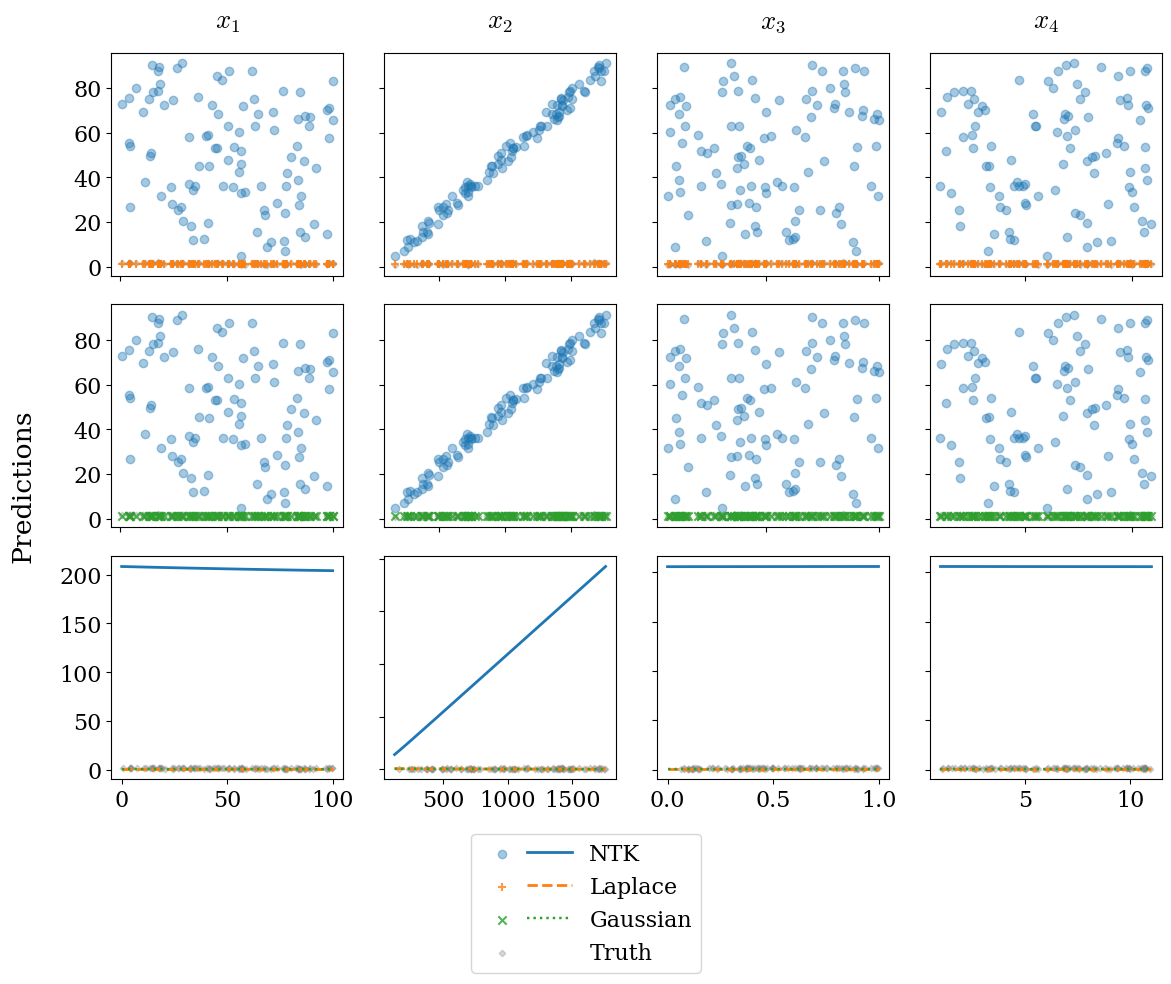

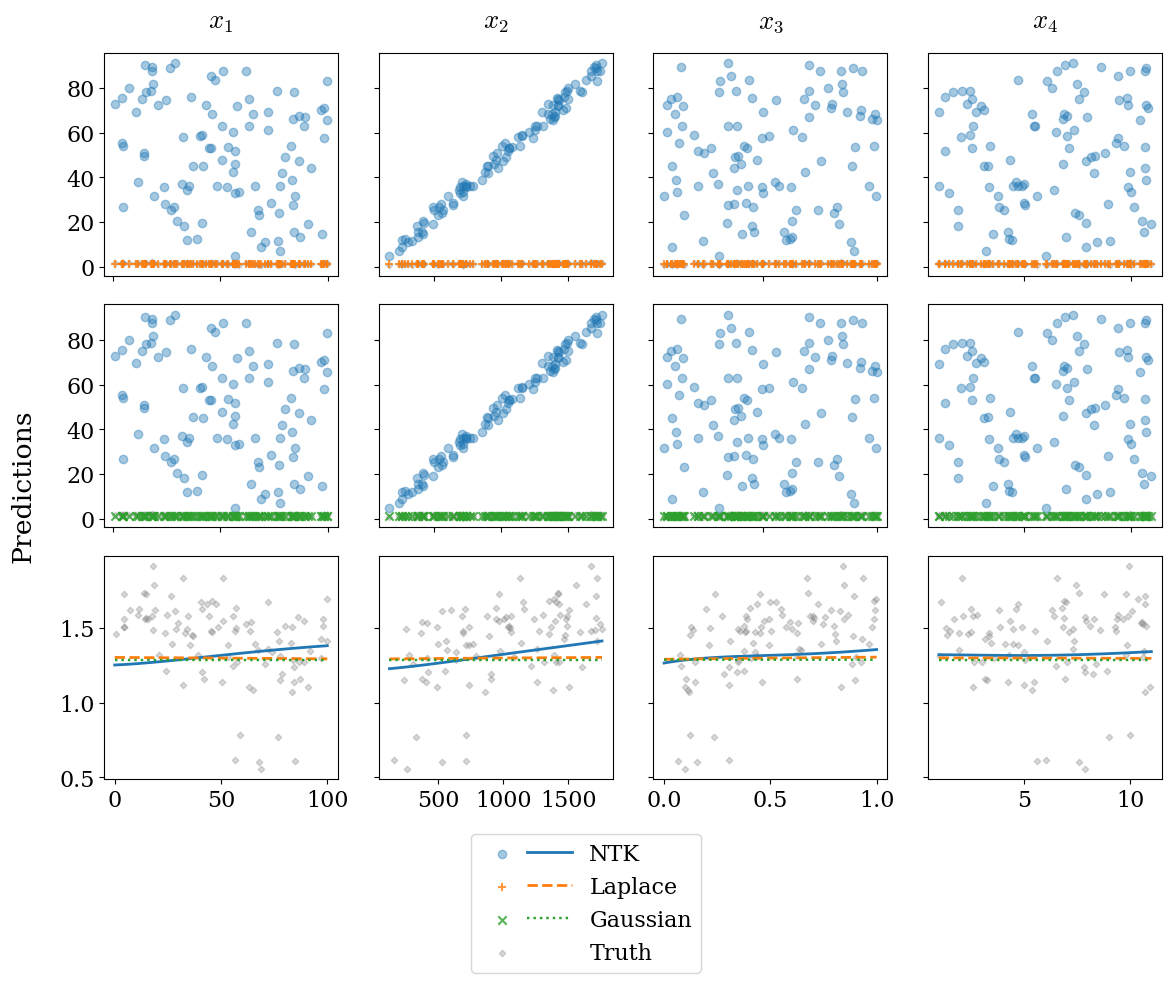

In [81]:
# F2 Sd outputs rescaled
# F2 Rd outputs rescaled
# F3 Sd inputs rescaled
# F3 Rd inputs rescaled
# 
# F3 Sd noisy   - 33
# F3 Sd         - 30
# F2 Sd         - 18
# F2 Sd noisy   - 21
pos = 27
data = True
# make_plot('none', pos)
make_plot('norm_y', pos)
# fig, _ = make_plot('rescale', pos, data)
make_plot('norm_y_rescale', pos, data)

In [276]:
fig.savefig("./exp/highD/F3D2Rdrescale.svg")

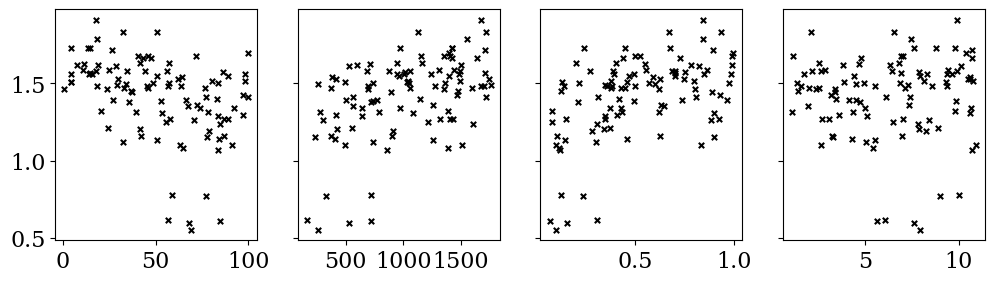

In [267]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3), sharey=True)
axes=axes.ravel()

plotting_X = experiment_output[pos]['dataset']['draw']
mean_lap = experiment_output[pos]['means'][1]
mean_gaus = experiment_output[pos]['means'][2]
mean_ntk = experiment_output[pos]['means'][0]
ground = experiment_output[pos]['dataset']['test'][1]

for i in range(0,4):
    if data:
        axes[i].scatter(plotting_X[:,i], ground, s=15, marker='x', c='black', alpha=1)